# Working with RPLAN data

This notebook is meant as a guide for how to represent, use, manipulate, and plot the floor plan data from [RPLAN](http://staff.ustc.edu.cn/~fuxm/projects/DeepLayout/index.html).

We have two main data formats that we use to describe (or attribute to) a floor plan:

- **Image**. Two frequently used formats:
    - 2D grayscale image with class labels directly as pixel values (0 - 17)
    - 3D colored image (through a custom coloring scheme: see `constants.py`)
- **Graph**. Two frequently used formats:
    - Simple graph: nodes have only class label attributes (0 - 17); edges have only type attribute ("door" or not).
    - Full graph: nodes have several attributes among which an ordered array defining the entity shape, the centroid, and the room category; edges have only type attribute ("door" or not).

Each floor plan in the original dataset has its own identifier (ID), *i.e.*, is assigned a number. I would highly encourage to set up different folders for each data format that contain the naming of the original identifiers (read: naming, such as `129.png`, `129.pickle`, `129.npy`, etc.). I did it like this:

```markdown
├── rplan\0-full
│   ├── original
│   ├── poly-aag
│   ├── geometry
```

`original` contains the original images, `poly-aag` contains the graphs saved as pickles ('poly-aag' stands for polygon-attributed access graph), and `geometry` contains the floor plans as a set of polygons.

Let's first set the path to the data folder:

In [1]:
import os
from constants import DATA_PATH

print(os.path.exists(DATA_PATH))

True


## Images

I dedicated a single folder for all the original images. You can download the original RPLAN dataset [here](https://docs.google.com/forms/d/e/1FAIpQLSfwteilXzURRKDI5QopWCyOGkeb_CFFbRwtQ0SOPhEg0KGSfw/viewform).

The following code highlights how the individual images are loaded, how they are colorized, and how they are plotted.

We do not use the whole dataset. Only the part for which our graph extraction algorithm (see `rplan.py`) could reliably extract a fully-connected graph (some floor plan in the original dataset had rooms with no doors) are considered in this study. I will come back to this later.

The 'valid' IDs are stored in `data/valid_ids.pickle`.

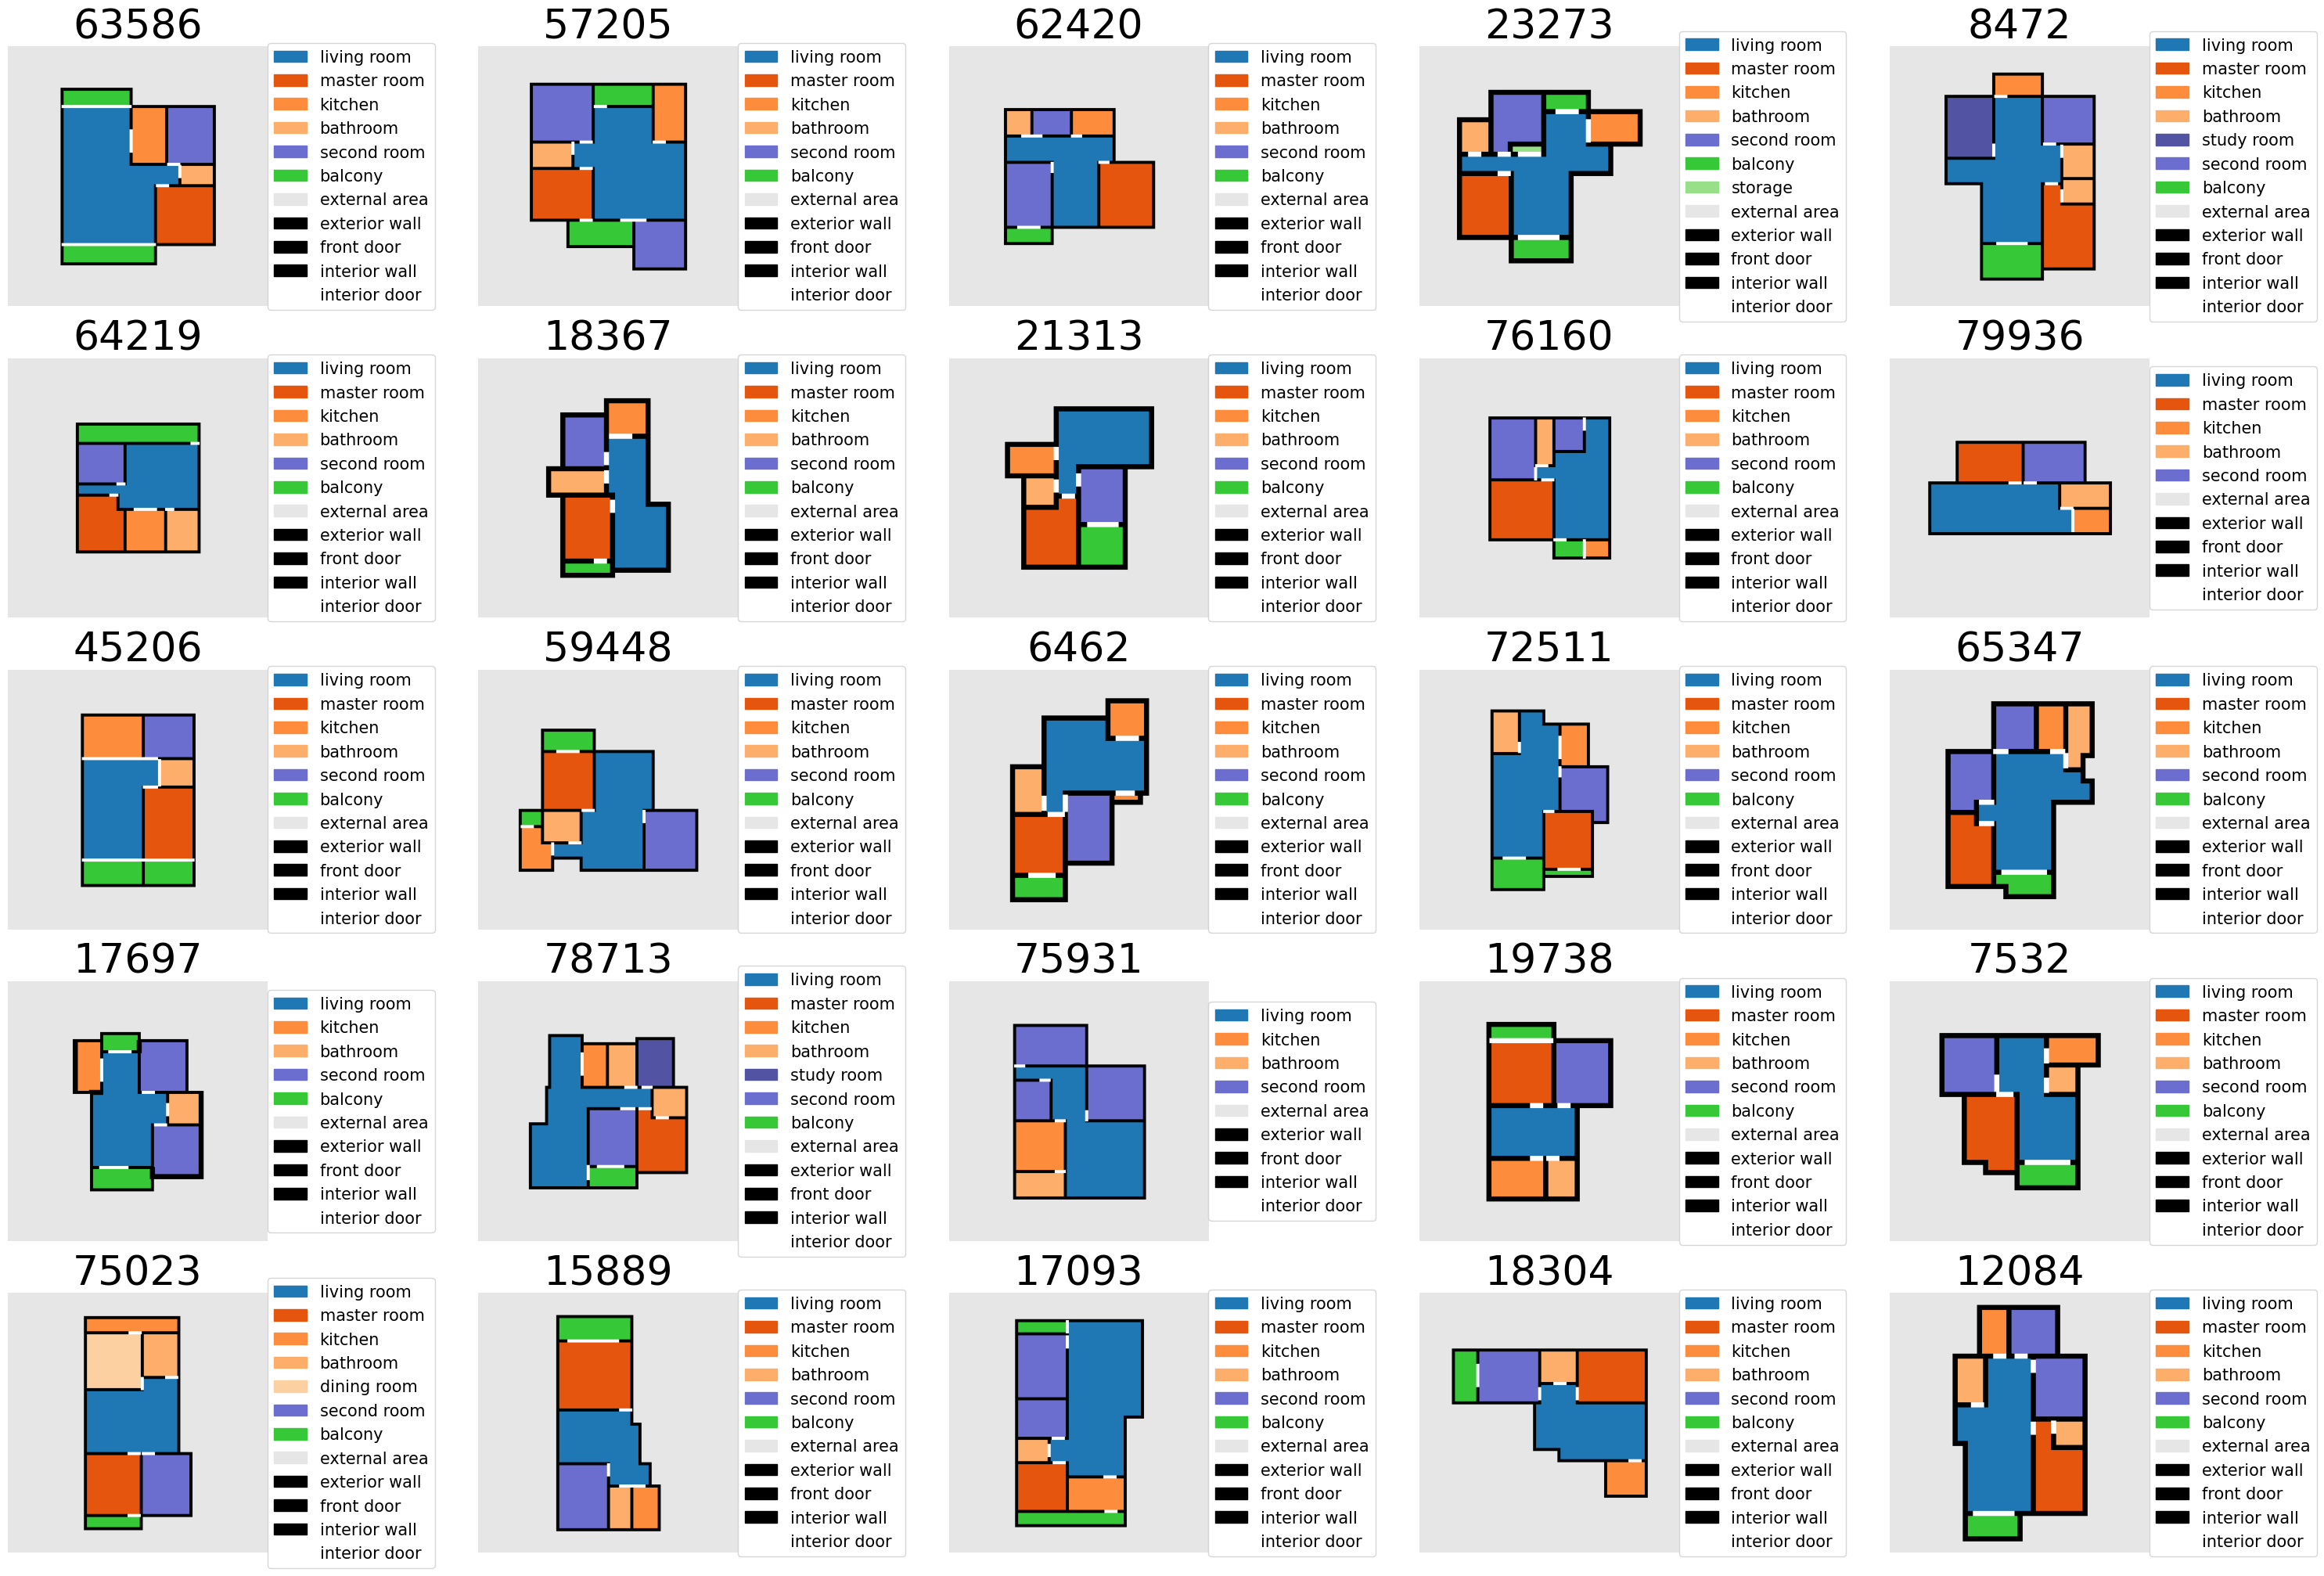

In [20]:
import numpy as np
import matplotlib.patches as mpatches

from utils import load_image_rplan, colorize_floorplan, gather_ids
from constants import CLASSES, CMAP_ROOMTYPE, CATEGORIES, COLOR_MAP_ROOMTYPE
from plot import set_figure

# gather IDs
ids = gather_ids(r'./data/valid_ids.pickle', shuffle=True)  # these are default setting (just to show you)

# set up figure
fs = 5  # figure size
n = 5  # number of columns (same as rows)
_, axs = set_figure(nc=5, nr=5, fs=fs, ratio=1.5, fs_legend=3)  # sets the figure; axs are flattened already

# plot some floor plans
for i, ax in enumerate(axs):

    # set id
    id = ids[i]

    # load and colorize floor plan image
    img = load_image_rplan(id, DATA_PATH)
    img_unique = np.unique(img)
    img = colorize_floorplan(img, CLASSES, CMAP_ROOMTYPE)

    # create legend
    legend_patches = [mpatches.Patch(color=np.array(CMAP_ROOMTYPE(i)).reshape(1,4), label=CATEGORIES[i])
                      for i in range(len(CATEGORIES)) if i in img_unique]
    _ = ax.legend(handles=legend_patches, bbox_to_anchor=(1, 0.5), loc='center left', borderaxespad=0.)

    # plot image
    ax.imshow(img)
    ax.set_title(id)
    _ = ax.axis('off')

## Graphs

The following code highlights how the individual graphs are loaded, how they are colorized, and how they are plotted.

we call the graph folder `poly-aag` (**Poly**gon **A**ttributed **A**ccess **G**raphs). We make primarily use of the following packages to process graphs; Pytorch Geometric (which allows for easy integration with learning frameworks; similar to Pytorch) and NetworkX. NetworkX we found is generally better for doing 'simple' operations on graphs and has many nice plot functions as well. Converting a graph from PyG to NX (or vice versa) is straightforward (see *e.g.*, `utils.py`>`pyg_to_nx`).

We extract the graphs from the images using `rplan.py` > `graph_extraction`. (This is still to be included in the repository.)

Since graphs are usually small, I developed a `graphs.pickle` which contains a dictionary with ID - graph key-value pairs for the whole dataset. The IDs (should) match with the IDs from `.\data\valid_ids.pickle`. From this file you can create the folder yourself by running the following code:

In [11]:
import torch

from utils import load_pickle
from tqdm.auto import tqdm

graphs_dict = load_pickle(r'./data/graphs.pickle')

graph_path = os.path.join(DATA_PATH, 'poly-aag')
os.makedirs(graph_path, exist_ok=True)

for id, graph in tqdm(graphs_dict.items()):
    save_path = os.path.join(graph_path, f'poly-aag-{id}')
    if os.path.exists(save_path):
        continue
    else:
        torch.save(graphs_dict[id], save_path)

  0%|          | 0/46063 [00:00<?, ?it/s]

Now we can plot the graphs (on top of the floor plan images):

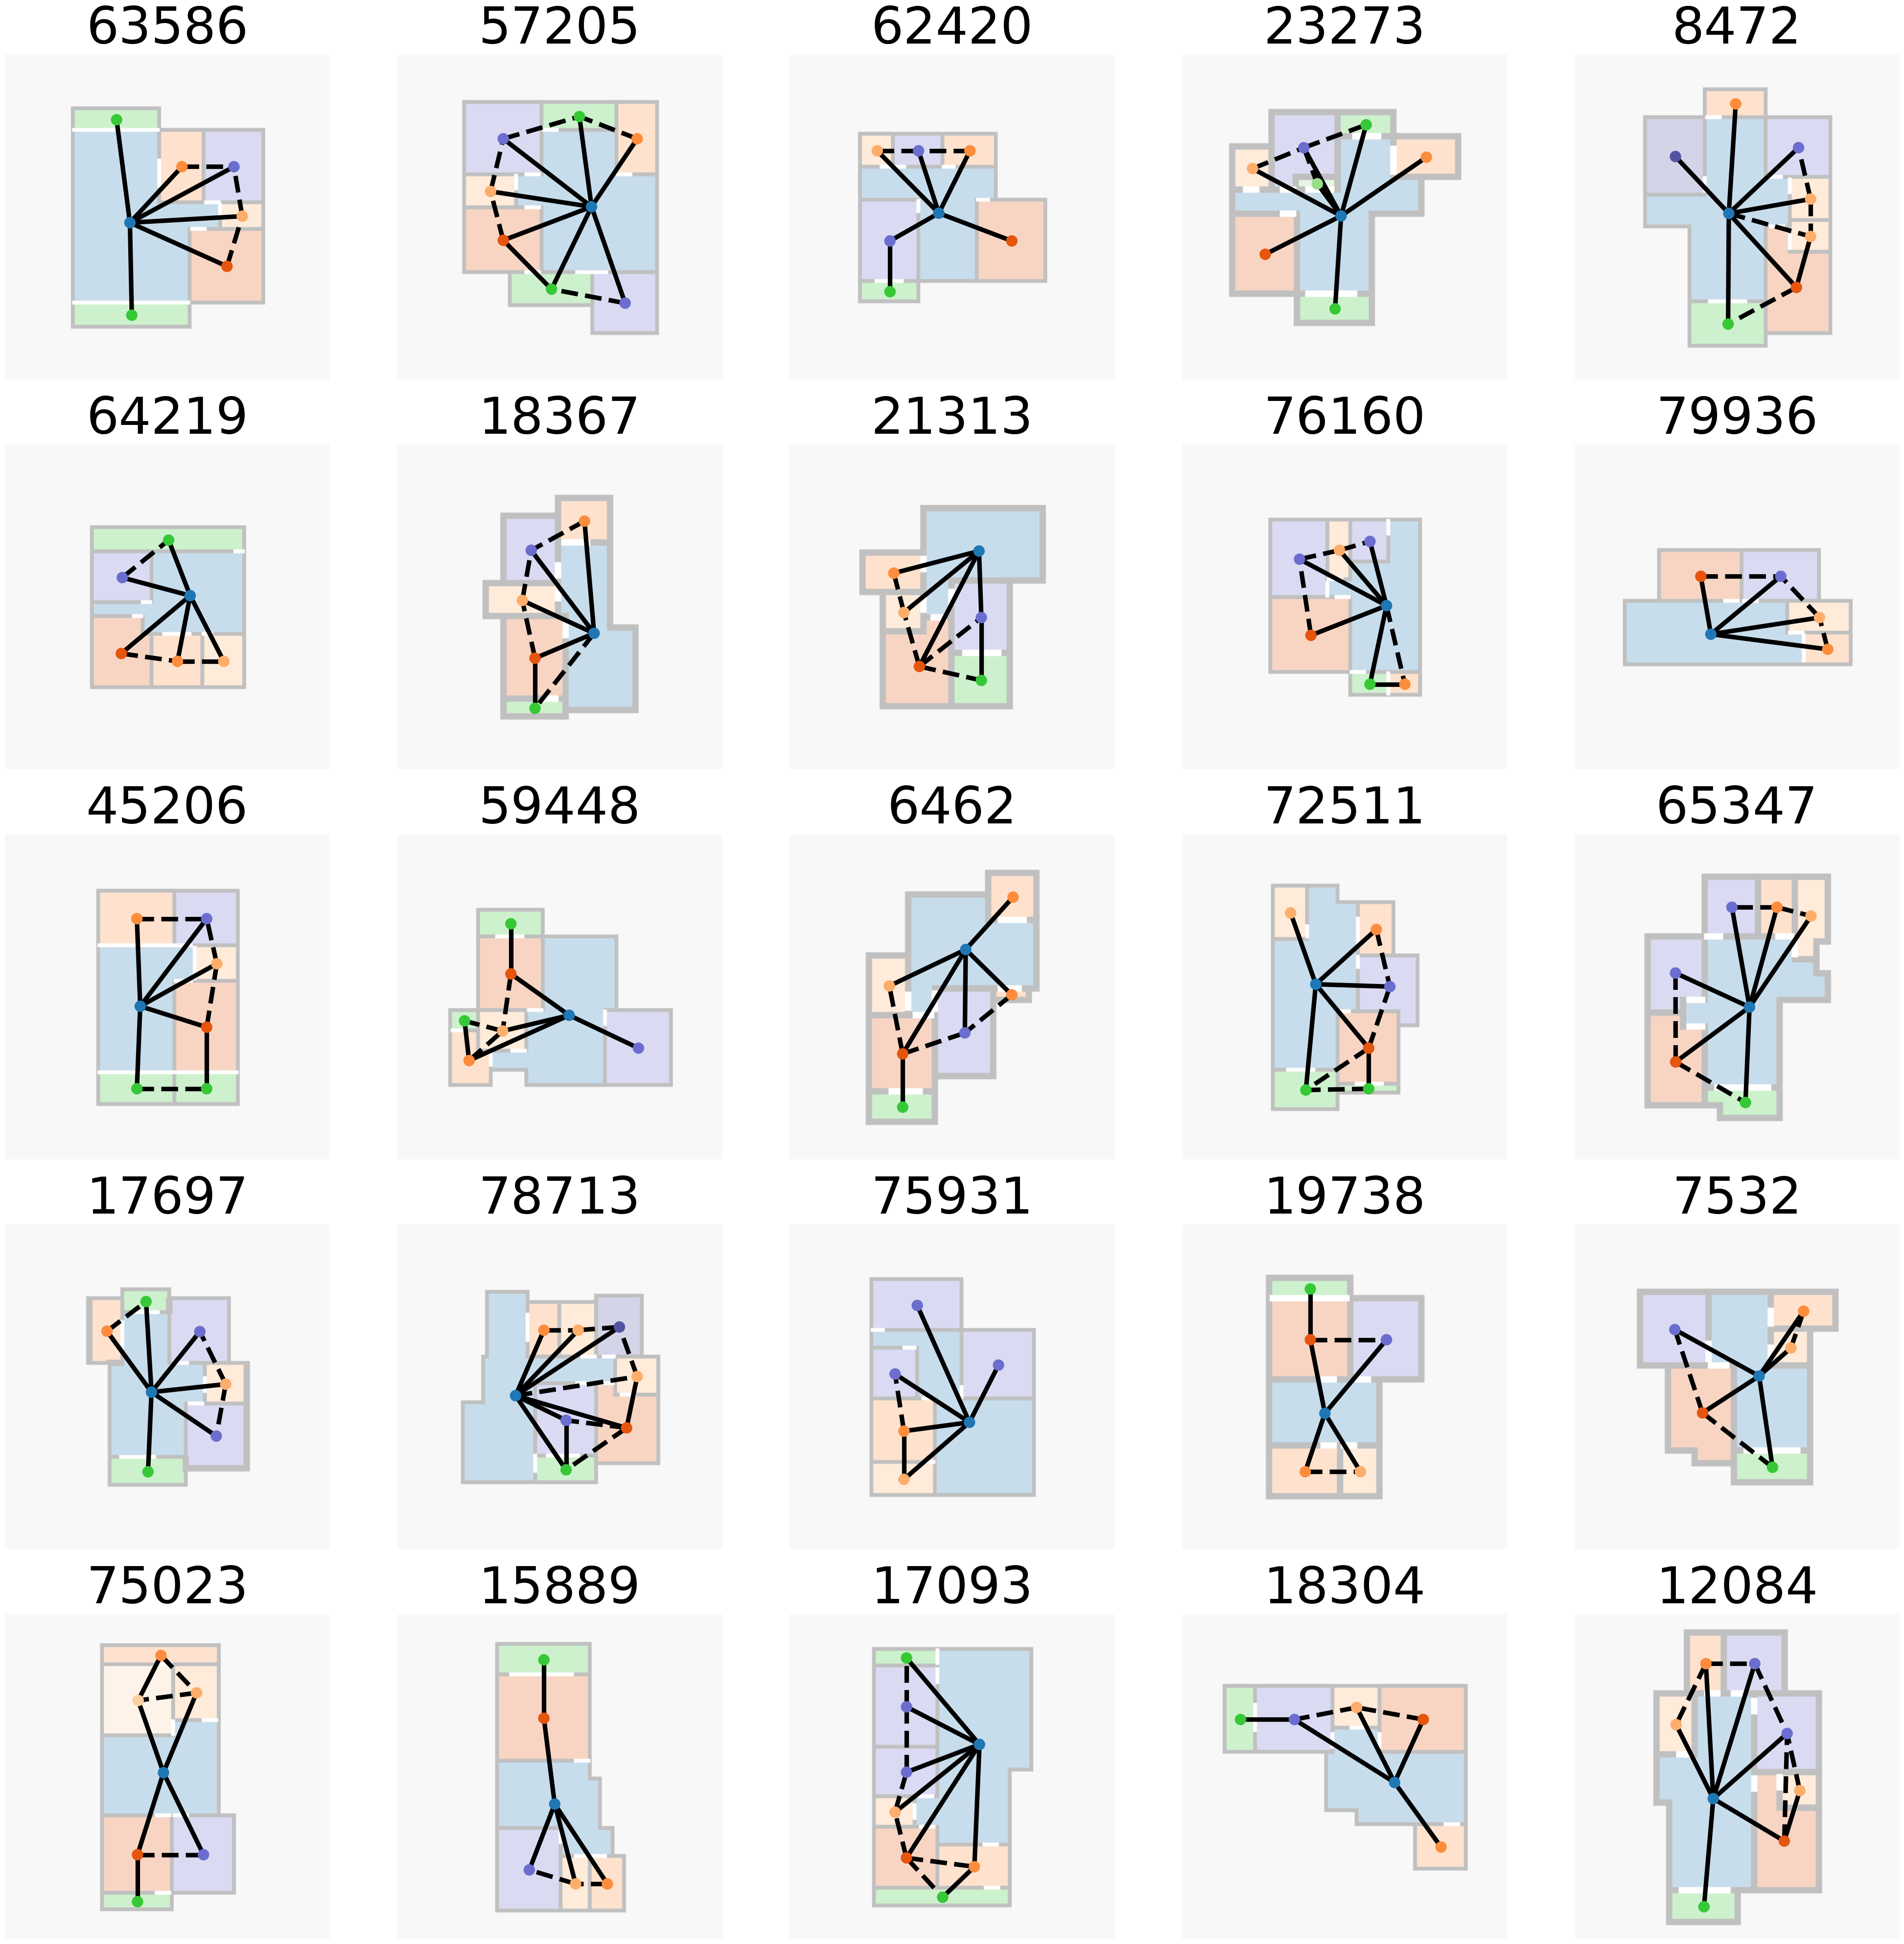

In [18]:
import torch
import numpy as np

from plot import plot_graph
from utils import pyg_to_nx

# set up figure
fs = 10
_, axs = set_figure(n, n, fs=fs)

# loop through identities
for i, ax in enumerate(axs):

    id = ids[i]

    # load Pytorch Geometric graph and convert to NetworkX graph.
    graph_pyg = torch.load(os.path.join(DATA_PATH, 'poly-aag', f'poly-aag-{id}'))
    graph_nx = pyg_to_nx(graph_pyg, node_attrs=['category', 'centroid'], edge_attrs=['door'])

    # get the positions of the nodes (through centroid);
    # get the coloring of the nodes (through category)
    pos = {n: np.array(graph_nx.nodes[n]['centroid']) for n in graph_nx.nodes}
    colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph_nx.nodes('category')]

    # plot graph
    plot_graph(graph_nx, ax,
               pos = pos,
               c_node=colors,
               dw_edge=True, c_edge=['black']*4,
               node_size=fs*25, edge_size=fs/1.5)

    # load; colorize; and plot the image as well (see previous code block)
    img = load_image_rplan(id, DATA_PATH)
    img = colorize_floorplan(img, CLASSES, CMAP_ROOMTYPE)

    ax.imshow(img, alpha=0.25)  # alpha for transparency
    ax.set_title(id)